## Дерево принятия решений (2D)
```
Рассмотрите те же данные, что и в задании 2. Разделите точки на классы с помощью
алгоритма CART(gini criterion). Ограничьте глубину дерева (по вашему выбору). Проверьте
точность полученного алгоритма с помощью метрики accuracy на тестовом наборе.
```

In [148]:
import numpy as np
from collections import Counter

In [220]:
labels = np.random.randint(0, 2, 200)
noise = 0.6
x = (np.random.rand(200) + labels) / 2
y = x*(-1) + np.random.rand(200) * noise

x = x.reshape(-1, 1)*200
y = y.reshape(-1, 1)*200
labels = labels.reshape(-1, 1)
data= np.hstack([x,y,labels]).astype("int")

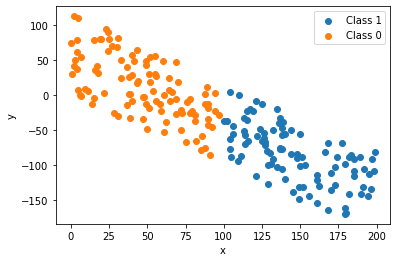

In [221]:
import matplotlib.pyplot as plt
plt.scatter(data[:,0][data[:,2] ==1], data[:,1][data[:,2] ==1], label='Class 1')
plt.scatter(data[:,0][data[:,2] ==0], data[:,1][data[:,2] ==0], label='Class 0')
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [222]:
np.random.shuffle(data)
train_x,train_y = data[:,[0,1]][:70],data[:,2][:70]
test_x,test_y = data[:,[0,1]][70:],data[:,2][70:]

In [223]:
def entropy(y):
    hist = np.bincount(y)
    ps = hist / len(y)
    return -np.sum([p * np.log2(p) for p in ps if p > 0])

In [224]:

class DecisionTree:

    def __init__(self, min_samples_split=2, max_depth=100, n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None

    def fit(self, X, y):
        if not self.n_feats:
            self.n_feats = X.shape[1]
        else:
            self.n_feats = min(self.n_feats, X.shape[1])
        # taking X and y
        # creating tree
        self.root = self._create_tree(X, y)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _create_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # stopping  working
        if (depth >= self.max_depth or n_labels == 1  or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            # returning Node
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

        # greedily select the best split according to information gain
        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)
        
        # grow the children that result from the split
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._create_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._create_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return Node(best_feat, best_thresh, left, right)

    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold

        return split_idx, split_thresh

    def _information_gain(self, y, X_column, split_thresh):
        # parent loss
        parent_entropy = entropy(y)

        # generate split
        left_idxs, right_idxs = self._split(X_column, split_thresh)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # compute the weighted avg. of the loss for the children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = entropy(y[left_idxs]), entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        # information gain is difference in loss before vs. after split
        ig = parent_entropy - child_entropy
        return ig

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common
    
    
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

In [225]:
from sklearn.model_selection import train_test_split

def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

clf = DecisionTree(max_depth=10)
clf.fit(train_x,train_y )
    
y_pred = clf.predict(test_x)
acc = accuracy(test_y,y_pred)

print ("Accuracy:", acc)

Accuracy: 0.9615384615384616


In [226]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=32).fit(train_x, train_y)

In [227]:
clf.score(test_x, test_y)

0.9923076923076923